In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install torch_geometric


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%%capture
!kaggle datasets download -d vitvhong/uplink
!unzip uplink.zip -d ./uplink
%cd uplink

In [4]:
import numpy as np
import torch
from torch_geometric.loader import  DataLoader
from torch_geometric.data import HeteroData, Data, Dataset, Batch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, ELU, Sigmoid, BatchNorm1d as BN, ReLU6 as ReLU6
import scipy.io
from torch_geometric.nn import HeteroConv, SAGEConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import matplotlib.pyplot as plt

In [5]:
train_layouts = 10000
test_layouts = 1000

In [6]:
data = scipy.io.loadmat('cf_train_6_30_2.mat')
beta_train = data['betas'][:train_layouts]
direct_train = data['directs'][:train_layouts]
cross_train = data['corsses'][:train_layouts].transpose(0,2,1)

In [7]:
test_data = scipy.io.loadmat('cf_test_6_30_2.mat')
beta_test = test_data['betas']
direct_test = test_data['directs']
cross_test = test_data['corsses'].transpose(0,2,1)

In [8]:
def normalize_data(train_data,test_data):
    train_mean = np.mean(train_data)
    train_std = np.std(train_data)
    norm_train = (train_data)/train_std
    norm_test = (test_data)/train_std
    n1, n2 = norm_train.shape[0], norm_test.shape[0]
    return norm_train, norm_test
norm_train_losses, norm_test_losses = normalize_data(beta_train**(1/2), beta_test**(1/2) )

In [9]:
## For GNNs, we allow train_K \neq test_K
train_K, train_M = beta_train.shape[2], beta_train.shape[1]
test_K, test_M = beta_test.shape[2], beta_test.shape[1]

In [10]:
class PCDataset(Dataset):
    def __init__(self, norm_losses, direct, cross, KM):
        self.norm_losses = norm_losses
        self.direct = torch.tensor(direct, dtype=torch.float)
        self.cross = torch.tensor(cross, dtype=torch.float)
        self.KM = KM
        self.get_cg()
        self.process()

    def build_graph(self, idx):
        edge_feature = self.norm_losses[idx, :, :].reshape((self.KM[0] * self.KM[1], 1), order='F')
        edge_feature = np.concatenate((edge_feature, np.ones_like(edge_feature)), axis=-1)
        edge_feature = torch.tensor(edge_feature, dtype=torch.float)

        edge_index = torch.tensor(self.adj, dtype=torch.long).t().contiguous()
        edge_index_t = torch.tensor(self.adj_t, dtype=torch.long).t().contiguous()
        ue_features = torch.ones((self.KM[0], 1))
        ap_features = torch.ones((self.KM[1], 1))

        data = HeteroData()
        data['UE'].x = ue_features
        data['AP'].x = ap_features
        data['UE', 'com-by', 'AP'].edge_index = edge_index
        data['UE', 'com-by', 'AP'].edge_attr = edge_feature
        data['AP', 'com', 'UE'].edge_index = edge_index_t
        data['AP', 'com', 'UE'].edge_attr = edge_feature

        return data

    def get_cg(self):
        self.adj = []
        self.adj_t = []
        for i in range(self.KM[0]):
            for j in range(self.KM[1]):
                self.adj.append([i, j])
                self.adj_t.append([j, i])

    def process(self):
        self.graph_list = [self.build_graph(i) for i in range(len(self.direct))]

    def __len__(self):
        return len(self.direct)

    def __getitem__(self, index):
        return self.graph_list[index], self.direct[index], self.cross[index]

In [11]:
def collate(samples):
    '''Pytorch Geometric collate function'''
    graphs, direct, cross = map(list, zip(*samples))
    batched_graph = Batch.from_data_list(graphs)
    return batched_graph, torch.stack(direct), torch.stack(cross)

In [12]:
train_data = PCDataset(norm_train_losses, direct_train, cross_train, (train_K, train_M))
test_data = PCDataset(norm_test_losses, direct_test, cross_test, (test_K, test_M))

# Mục mới

In [13]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_data, 1000, shuffle=False, collate_fn=collate)

In [14]:
def rate_loss(allocs, directlink_channel_losses, crosslink_channel_losses, test_mode = False):
    SINRs_numerators = allocs * directlink_channel_losses**2
    SINRs_denominators = torch.squeeze(torch.matmul(crosslink_channel_losses, torch.unsqueeze(allocs, axis=-1))) + directlink_channel_losses
    SINRs = SINRs_numerators / SINRs_denominators
    rates = torch.log2(1 + SINRs)
    min_rate = torch.min(rates, dim = 1)[0] # take min
    if test_mode:
        return min_rate
    else:
        return -torch.mean(min_rate)

In [15]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class EdgeConv(MessagePassing):
    def __init__(self, input_dim, node_dim, **kwargs):
        super(EdgeConv, self).__init__(aggr='mean')  # mean aggregation
        self.lin = MLP([input_dim, 32])
        self.res_lin = Lin(node_dim, 32)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):

        feat_src, feat_dst = x


        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)


        return self.bn(out + self.res_lin(feat_dst))

    def message(self, x_j, x_i, edge_attr):
        # Tạo ra thông điệp từ các nút nguồn, nút đích và đặc tính cạnh
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        return self.lin(out)

    def update(self, aggr_out):
        # Cập nhật giá trị nút đích sau khi tập hợp
        return aggr_out



In [16]:
class RGCN(nn.Module):
    def __init__(self):
        super(RGCN, self).__init__()
        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(4, 1),
            ('AP', 'com', 'UE'): EdgeConv(4, 1)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(66, 32),
            ('AP', 'com', 'UE'): EdgeConv(66, 32)
        }, aggr='mean')

        self.conv3 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(66, 32),
            ('AP', 'com', 'UE'): EdgeConv(66, 32)
        }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])

    def forward(self,x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out


In [17]:
model = RGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [18]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 14593


In [19]:
def train_model(epoch, model, optimizer, train_loader):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for batch_idx, (data, d_train, c_train) in enumerate(train_loader):
        K = d_train.shape[-1]
        n = len(data['UE'].x)
        bs = len(data['UE'].x) // K

        optimizer.zero_grad()

        # Lấy các đặc trưng nút từ từ điển x_dict
        user_feats = data['AP'].x
        item_feats = data['UE'].x
        node_features = {'AP': user_feats, 'UE': item_feats}

        # Truyền qua mô hình, bao gồm cả edge_attr_dict
        output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)

        # Tính loss và thực hiện backpropagation
        loss = rate_loss(output, d_train, c_train)
        loss.backward()

        loss_all += loss.item() * bs
        optimizer.step()

    return loss_all / len(train_loader.dataset)

def test_model(loader, model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for (data, d_test, c_test) in loader:
            K = d_test.shape[-1]
            n = len(data['UE'].x)
            bs = len(data['UE'].x) // K

            # Lấy các đặc trưng nút từ từ điển x_dict
            user_feats = data['AP'].x
            item_feats = data['UE'].x
            # Create a dictionary for node features
            node_features = {'AP': user_feats, 'UE': item_feats}

            output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)

            # Tính loss
            loss = rate_loss(output, d_test, c_test)
            correct += loss.item() * bs

    return correct / len(loader.dataset)

In [20]:
record_gnn = []

for epoch in range(0, 100):
    if epoch % 1 == 0:
        with torch.no_grad():
            test_rate = test_model(test_loader, model)
            train_rate = test_model(train_loader, model)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
        record_gnn.append([train_rate, test_rate])

    train_model(epoch, model, optimizer, train_loader )
    scheduler.step()


Epoch 000, Train Rate: -0.2396, Test Rate: -0.2634
Epoch 001, Train Rate: -0.4320, Test Rate: -0.4500
Epoch 002, Train Rate: -0.5186, Test Rate: -0.5308
Epoch 003, Train Rate: -0.5320, Test Rate: -0.5418
Epoch 004, Train Rate: -0.5617, Test Rate: -0.5688
Epoch 005, Train Rate: -0.5725, Test Rate: -0.5805
Epoch 006, Train Rate: -0.5903, Test Rate: -0.5961
Epoch 007, Train Rate: -0.5836, Test Rate: -0.5897
Epoch 008, Train Rate: -0.5828, Test Rate: -0.5885
Epoch 009, Train Rate: -0.5923, Test Rate: -0.5979
Epoch 010, Train Rate: -0.5913, Test Rate: -0.5966
Epoch 011, Train Rate: -0.6052, Test Rate: -0.6101
Epoch 012, Train Rate: -0.6235, Test Rate: -0.6269
Epoch 013, Train Rate: -0.6225, Test Rate: -0.6264
Epoch 014, Train Rate: -0.6257, Test Rate: -0.6274
Epoch 015, Train Rate: -0.6267, Test Rate: -0.6297
Epoch 016, Train Rate: -0.6366, Test Rate: -0.6393
Epoch 017, Train Rate: -0.6229, Test Rate: -0.6235
Epoch 018, Train Rate: -0.6326, Test Rate: -0.6329
Epoch 019, Train Rate: -0.6388,

# Quantum MLP

# HQGNN Amplitude Embedding

In [24]:
pip install pennylane

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 5
n_layers =  10
dev = qml.device('default.qubit', wires=n_qubits)


In [26]:
n_layers_circuit_X = 2
def circuit_X_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_X):
        circuit_X_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X = { "layer_weights": (n_layers_circuit_X, n_qubits)}

In [27]:
n_layers_circuit_Z = 2
def circuit_Z_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_Z):
        circuit_Z_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z = { "layer_weights": (n_layers_circuit_Z, n_qubits)}

In [28]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, **kwargs):
        super(Q_layer, self).__init__(aggr='mean')  # mean aggregation
        self.lin_res = qml.qnn.TorchLayer(circuit_Z, weight_shapes_circuit_Z)
        self.lin_qml = qml.qnn.TorchLayer(circuit_X, weight_shapes_circuit_X)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, 2 ** n_qubits)
        self.bn = BN(2 ** n_qubits)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(feat_dst)
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [29]:
class RGCN_Hybrid_mid(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid, self).__init__()
        out_dim = 2**n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(1, 1, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(1, 1, edge_dim,)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
             ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [30]:
model_qml_amplitude = RGCN_Hybrid_mid().to()

optimizer_qml_amplitude = torch.optim.Adam(model_qml_amplitude.parameters(), lr=5e-4)
scheduler_qml_amplitude = torch.optim.lr_scheduler.StepLR(optimizer_qml_amplitude, step_size=10, gamma=0.6)

In [31]:
trainable_params = sum(p.numel() for p in model_qml_amplitude.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 9977


In [32]:
record_amplitude = []

for epoch in range(0, 100):

    with torch.no_grad():
        test_rate = test_model(test_loader, model_qml_amplitude)
        train_rate = test_model(train_loader, model_qml_amplitude)
        record_amplitude.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model(epoch, model_qml_amplitude, optimizer_qml_amplitude, train_loader)
    scheduler_qml_amplitude.step()

Epoch 00, Train Rate: -0.2393, Test Rate: -0.2630
Epoch 01, Train Rate: -0.4993, Test Rate: -0.5104
Epoch 02, Train Rate: -0.4790, Test Rate: -0.4755
Epoch 03, Train Rate: -0.5324, Test Rate: -0.5354
Epoch 04, Train Rate: -0.5514, Test Rate: -0.5549
Epoch 05, Train Rate: -0.5691, Test Rate: -0.5711
Epoch 06, Train Rate: -0.4966, Test Rate: -0.4998
Epoch 07, Train Rate: -0.5479, Test Rate: -0.5535
Epoch 08, Train Rate: -0.5875, Test Rate: -0.5839
Epoch 09, Train Rate: -0.6204, Test Rate: -0.6203
Epoch 10, Train Rate: -0.6267, Test Rate: -0.6260
Epoch 11, Train Rate: -0.6509, Test Rate: -0.6527
Epoch 12, Train Rate: -0.6224, Test Rate: -0.6236
Epoch 13, Train Rate: -0.6348, Test Rate: -0.6375
Epoch 14, Train Rate: -0.5928, Test Rate: -0.5945
Epoch 15, Train Rate: -0.5774, Test Rate: -0.5833
Epoch 16, Train Rate: -0.6028, Test Rate: -0.6020
Epoch 17, Train Rate: -0.5954, Test Rate: -0.5959
Epoch 18, Train Rate: -0.6425, Test Rate: -0.6442
Epoch 19, Train Rate: -0.5253, Test Rate: -0.5238


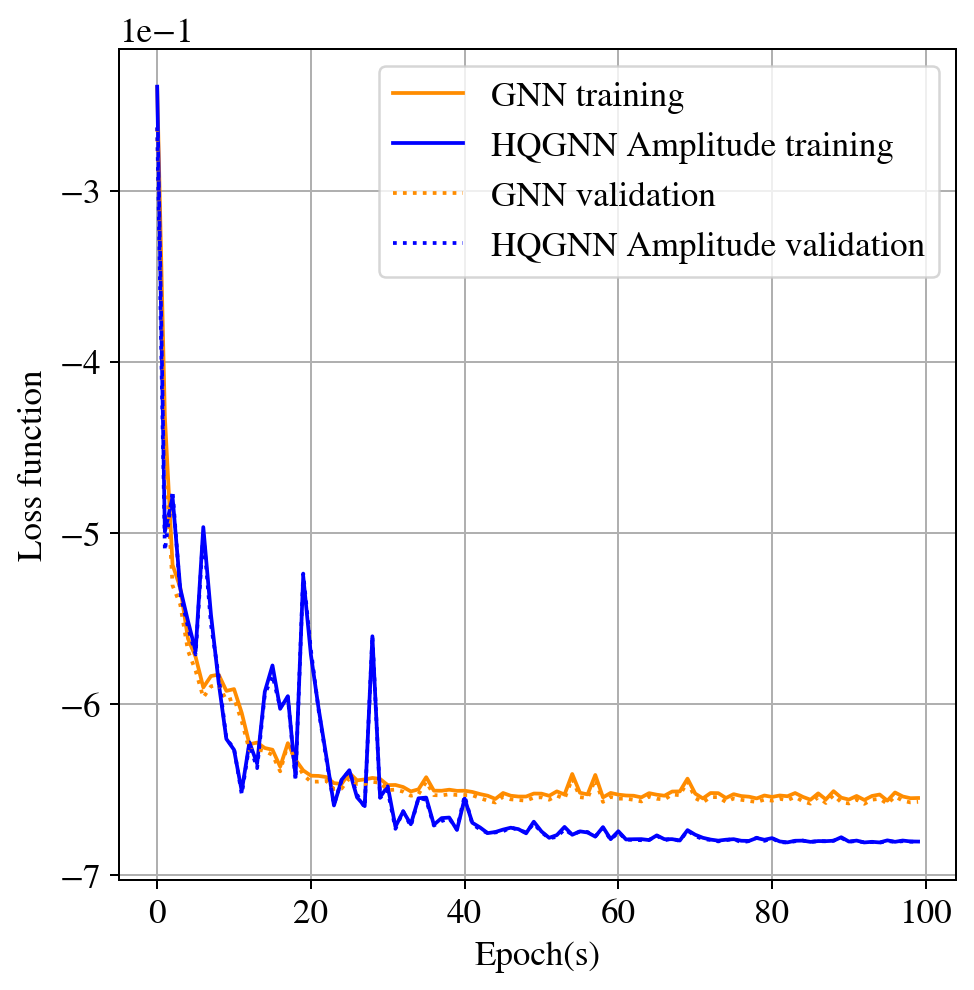

In [35]:
#record_gnn = np.load('gnn.npy')
# record_amplitude = np.load('amplitude.npy')
# record_angle = np.load('angle.npy')

record_gnn = np.array(record_gnn)
record_amplitude = np.array(record_amplitude)
# record_angle = np.array(record_angle)
# record_DL = np.array(record_edge)
skip = 1;start = 0
gnn_train = record_gnn[start::skip, 0]
amplitude_train = record_amplitude[start::skip, 0]
#angle_train = record_angle[0::skip, 0]
# DL_train = record_DL[start::skip, 0]

gnn_test = record_gnn[start::skip, 1]
amplitude_test = record_amplitude[start::skip, 1]
#angle_test = record_angle[0::skip, 1]
# DL_test = record_DL[start::skip, 1]

from scipy.signal import savgol_filter

# gnn_train_smooth = savgol_filter(gnn_train, window_length=7, polyorder=3)
# amplitude_train_smooth = savgol_filter(amplitude_train, window_length=7, polyorder=3)
# DL_train_smooth = savgol_filter(DL_train, window_length=7, polyorder=3)

# gnn_test_smooth = savgol_filter(gnn_test, window_length=7, polyorder=3)
# amplitude_test_smooth = savgol_filter(amplitude_test, window_length=7, polyorder=3)
# DL_test_smooth = savgol_filter(DL_test, window_length=7, polyorder=3)

plt.rc("text", usetex=False)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(6, 6), dpi=180)

x_values = np.arange(start, 100, skip)

plt.plot(x_values, gnn_train, '-',color = 'darkorange', label='GNN training')
plt.plot(x_values, amplitude_train, 'b-', label='HQGNN Amplitude training')
# plt.plot(x_values, DL_train_smooth, 'k-', label='FCNN training')

plt.plot(x_values, gnn_test, ':', color = 'darkorange', markersize=7, label='GNN validation', markevery=10)
plt.plot(x_values, amplitude_test, 'b:', markersize=7, label='HQGNN Amplitude validation', markevery=10)
# plt.plot(x_values, DL_test_smooth, 'k:', markersize=7, label='FCNN validation', markevery=10)


plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.xlabel('Epoch(s)')
plt.ylabel('Loss function')
plt.legend()

plt.grid(True)
plt.savefig('Convergence')
plt.show()

In [36]:
gnn_q_rates = None
for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output = model_qml_amplitude(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)

    gnn_q_rates = rate_loss(output, d_test, c_test, True).flatten().detach().numpy()

In [37]:
print(f'QGNN in middle: {np.mean(gnn_q_rates)}')
print(f'GNN: {np.mean(gnn_rates)}')

QGNN in middle: 0.6803564429283142
GNN: 0.6584622859954834


# Angle Embedding

In [38]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 5
dev = qml.device('default.qubit', wires=n_qubits)


In [39]:
n_layers_circuit_X2 = 2
def circuit_X2_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_X2):
        circuit_X2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X2 = { "layer_weights": (n_layers_circuit_X2, n_qubits)}

In [40]:
n_layers_circuit_Z2 = 2
def circuit_Z2_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_Z2):
        circuit_Z2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z2 = { "layer_weights": (n_layers_circuit_Z2, n_qubits)}

In [41]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer_angle(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, out_dim, **kwargs):
        super(Q_layer_angle, self).__init__(aggr='mean')  
        self.lin_res = qml.qnn.TorchLayer(circuit_X2, weight_shapes_circuit_X2)
        self.lin_qml = qml.qnn.TorchLayer(circuit_Z2, weight_shapes_circuit_Z2)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, out_dim)
        self.linear = nn.Linear(dst_dim, n_qubits)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(self.linear(feat_dst))
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [42]:
class RGCN_Hybrid_mid_angle(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid_angle, self).__init__()
        out_dim = n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(1, 1, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(1, 1, edge_dim,out_dim)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
             ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [43]:
model_qml_mid_angle = RGCN_Hybrid_mid_angle().to()

optimizer_qml_mid_angle = torch.optim.Adam(model_qml_mid_angle.parameters(), lr=5e-4)
scheduler_qml_mid_angle = torch.optim.lr_scheduler.StepLR(optimizer_qml_mid_angle, step_size=10, gamma=0.6)

In [44]:
trainable_params = sum(p.numel() for p in model_qml_mid_angle.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3151


In [45]:
record_angle = []

for epoch in range(0, 100):

    with torch.no_grad():
        test_rate = test_model(test_loader, model_qml_mid_angle)
        train_rate = test_model(train_loader, model_qml_mid_angle)
        record_angle.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model(epoch, model_qml_mid_angle, optimizer_qml_mid_angle, train_loader)
    scheduler_qml_mid_angle.step()

Epoch 00, Train Rate: -0.2374, Test Rate: -0.2611
Epoch 01, Train Rate: -0.5251, Test Rate: -0.5387
Epoch 02, Train Rate: -0.5852, Test Rate: -0.5912
Epoch 03, Train Rate: -0.6038, Test Rate: -0.6042
Epoch 04, Train Rate: -0.6128, Test Rate: -0.6142
Epoch 05, Train Rate: -0.6105, Test Rate: -0.6155
Epoch 06, Train Rate: -0.6189, Test Rate: -0.6204
Epoch 07, Train Rate: -0.6224, Test Rate: -0.6239
Epoch 08, Train Rate: -0.6211, Test Rate: -0.6213
Epoch 09, Train Rate: -0.6265, Test Rate: -0.6288
Epoch 10, Train Rate: -0.6217, Test Rate: -0.6235
Epoch 11, Train Rate: -0.6318, Test Rate: -0.6338
Epoch 12, Train Rate: -0.6337, Test Rate: -0.6354
Epoch 13, Train Rate: -0.6322, Test Rate: -0.6329
Epoch 14, Train Rate: -0.6381, Test Rate: -0.6384
Epoch 15, Train Rate: -0.6367, Test Rate: -0.6387
Epoch 16, Train Rate: -0.6403, Test Rate: -0.6434
Epoch 17, Train Rate: -0.6395, Test Rate: -0.6415
Epoch 18, Train Rate: -0.6441, Test Rate: -0.6460
Epoch 19, Train Rate: -0.6280, Test Rate: -0.6315


In [ ]:
np.save('gnn.npy', record_gnn)
np.save('amplitude.npy', record_amplitude)
np.save('angle.npy', record_angle)

# CDF

In [ ]:
num = 1000

In [ ]:
test_5 = scipy.io.loadmat('cf_100_5_test.mat')
beta_5 = test_5['betas'][:num]
direct_5 = test_5['directs'][:num]
cross_5 = test_5['corsses'][:num].transpose(0,2,1)

In [ ]:
norm_train_5, norm_test_5 = normalize_data(beta_5**(1/2), beta_5**(1/2) )

In [ ]:
test_5 = PCDataset(norm_test_5, direct_5, cross_5, (5, 100))
test_5_loader = DataLoader(test_5, test_layouts, shuffle=False, collate_fn=collate)

In [ ]:
test_4 = scipy.io.loadmat('cf_20_4_test.mat')
beta_4 = test_4['betas'][:num]
direct_4 = test_4['directs'][:num]
cross_4 = test_4['corsses'][:num].transpose(0,2,1)

In [ ]:
norm_train_4, norm_test_4 = normalize_data(beta_4**(1/2), beta_4**(1/2) )

In [ ]:
test_4 = PCDataset(norm_train_4, direct_4, cross_4, (4, 20))
test_4_loader = DataLoader(test_4, test_layouts, shuffle=False, collate_fn=collate)

In [ ]:
all_one_rates_5 = []
random_rates_5 = []
gnn_rates_amplitude_5 = []
for (data, d_test, c_test) in test_5_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output1 = model_qml_amplitude(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    gnn_rates_amplitude_5.append(rate_loss(output1, d_test, c_test, True).flatten().detach().numpy())
    full = torch.ones_like(output1)
    all_one_rates_5.append(rate_loss(full, d_test, c_test, True).flatten().detach().numpy())
    rand = torch.rand_like(output1)
    random_rates_5.append(rate_loss(rand, d_test, c_test, True).flatten().detach().numpy())

In [ ]:
min_rate, max_rate = 0, 3.25
y_axis = np.linspace(0, 1.0, num + 2, endpoint=False)
gnn_rates_amplitude_5 = np.concatenate(gnn_rates_amplitude_5)
random_rates_5 = np.concatenate(random_rates_5)
all_one_rates_5 = np.concatenate(all_one_rates_5)

all_one_rates_5 = np.sort(all_one_rates_5) 
gnn_rates_amplitude_5 = np.sort(gnn_rates_amplitude_5)
random_rates_5 = np.sort(random_rates_5)
gnn_rates_amplitude_5 = np.insert(gnn_rates_amplitude_5, 0, min_rate); gnn_rates_amplitude_5 = np.insert(gnn_rates_amplitude_5,num+1,max_rate)
#gnn_rates_angle = np.insert(gnn_rates_angle, 0, min_rate); gnn_rates_angle = np.insert(gnn_rates_angle,201,max_rate)
random_rates_5 = np.insert(random_rates_5, 0, min_rate); random_rates_5 = np.insert(random_rates_5, num+1, max_rate)
#opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates, 201, max_rate)
all_one_rates_5 = np.insert(all_one_rates_5, 0, min_rate); all_one_rates_5 = np.insert(all_one_rates_5,num+1,max_rate)

In [ ]:
all_one_4 = []
random_4 = []
gnn_amplitude_4 = []
for (data, d_test, c_test) in test_4_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output1 = model_qml_amplitude(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    #output2 = model_qml_mid_angle(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    gnn_amplitude_4.append(rate_loss(output1, d_test, c_test, True).flatten().detach().numpy())
    #gnn_angle_5 = rate_loss(output2, d_test, c_test, True).flatten().detach().numpy()
    full = torch.ones_like(output1)
    all_one_4.append(rate_loss(full, d_test, c_test, True).flatten().detach().numpy())
    rand = torch.rand_like(output1)
    random_4.append(rate_loss(rand, d_test, c_test, True).flatten().detach().numpy())

In [ ]:
min_rate, max_rate = 0, 2
y_axis = np.linspace(0, 1.0, num + 2, endpoint=False)
gnn_amplitude_4 = np.concatenate(gnn_amplitude_4)
random_4 = np.concatenate(random_4)
all_one_4 = np.concatenate(all_one_4)
all_one_4 = np.sort(all_one_4) 
gnn_amplitude_4  = np.sort(gnn_amplitude_4 )
random_4 = np.sort(random_4)
gnn_amplitude_4 = np.insert(gnn_amplitude_4, 0, min_rate); gnn_amplitude_4 = np.insert(gnn_amplitude_4,num+1,max_rate)
random_4= np.insert(random_4, 0, min_rate); random_4 = np.insert(random_4, num + 1, max_rate)
all_one_4 = np.insert(all_one_4, 0, min_rate); all_one_4 = np.insert(all_one_4,num + 1,max_rate)

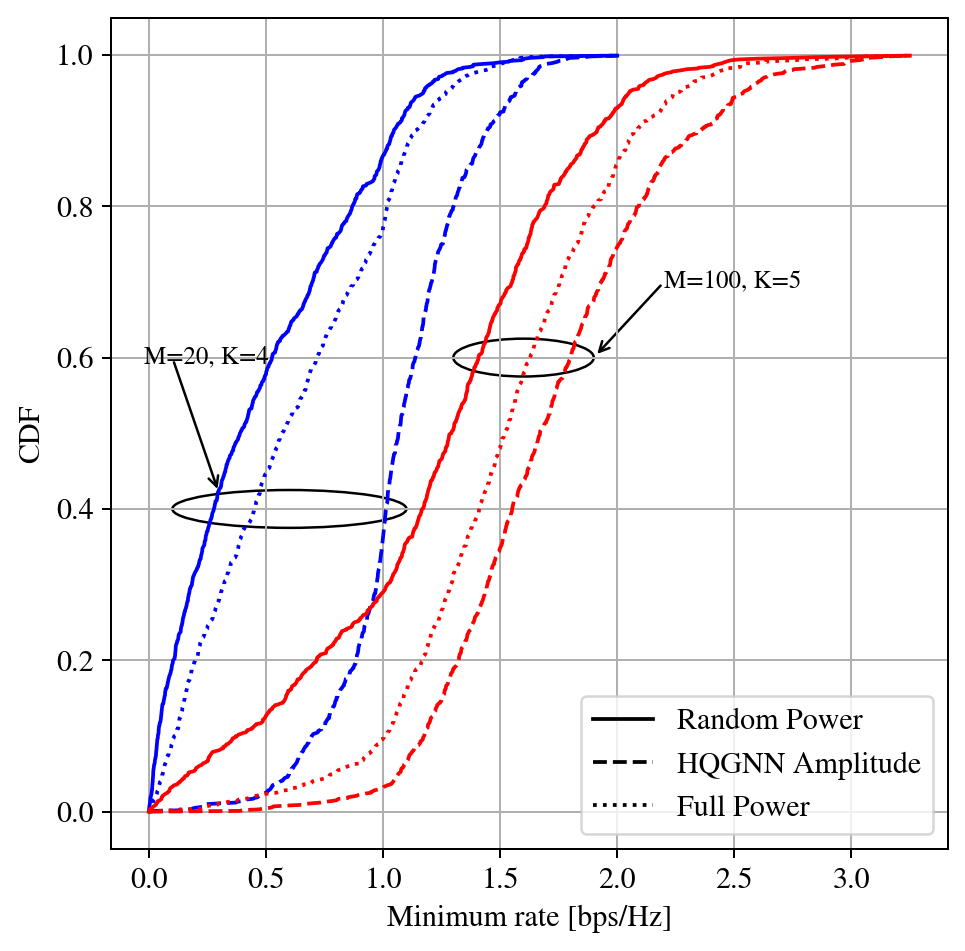

In [ ]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, FancyArrowPatch

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(6, 6), dpi=180)
# First network setting (e.g., M=20, K=4)
ax.plot(random_4, y_axis, label='Random Power', color='blue')
ax.plot(gnn_amplitude_4, y_axis, label='HQGNN Amplitude', color='blue', linestyle='--')
ax.plot(all_one_4, y_axis, label='Maximum Power', color='blue', linestyle=':')

# Second network setting (e.g., M=100, K=5)
ax.plot(random_rates_5, y_axis, label='Random Power', color='red')
ax.plot(gnn_rates_amplitude_5, y_axis, label='HQGNN Amplitude', color='red', linestyle='--')
ax.plot(all_one_rates_5, y_axis, label='Maximum Power', color='red', linestyle=':')

# Custom legend
custom_lines = [
    #Line2D([0], [0], color='white', label='M=30, K=6'),
    Line2D([0], [0], color='black', label='Random Power'),
    Line2D([0], [0], color='black', linestyle='--', label='HQGNN Amplitude'),
    Line2D([0], [0], color='black', linestyle=':', label='Full Power'),
    #Line2D([0], [0], color='white', label='M=100, K=5'),
    #Line2D([0], [0], color='red', label='Random Power'),
    #Line2D([0], [0], color='red', linestyle='--', label='HQGNN Amplitude'),
    #Line2D([0], [0], color='red', linestyle=':', label='Full Power'),
    #Line2D([0],[0],label='Optimal')
]

# Add custom legend to the plot
ax.legend(handles=custom_lines, loc='lower right', frameon=True)

# Axis labels and grid
ax.set_xlabel('Minimum rate [bps/Hz]')
ax.set_ylabel('CDF')
ax.grid()

# Thêm hình elip cho vùng CDF của Random Power (blue) và HQGNN Amplitude (blue)
ellipse1 = Ellipse(xy=(0.6, 0.4), width=1, height=0.05, edgecolor='black', facecolor='none', linewidth=1)
ax.add_patch(ellipse1)

# Thêm hình elip cho vùng CDF của Random Power (red) và HQGNN Amplitude (red)
ellipse2 = Ellipse(xy=(1.6, 0.6), width=0.6, height=0.05, edgecolor='black', facecolor='none', linewidth=1)
ax.add_patch(ellipse2)


ax.text(-0.02, 0.6, "M=20, K=4", fontsize=10, verticalalignment='center', horizontalalignment='left', color='black')
arrow1 = FancyArrowPatch((0.1, 0.6), (0.3, 0.42), arrowstyle='->', mutation_scale=10, color='black')
ax.add_patch(arrow1)

ax.text(2.2, 0.7, "M=100, K=5", fontsize=10, verticalalignment='center', horizontalalignment='left', color='black')
arrow2 = FancyArrowPatch((2.2, 0.7), (1.9, 0.6), arrowstyle='->', mutation_scale=10, color='black')
ax.add_patch(arrow2)

# Hiển thị đồ thị
plt.show()


DL Method https://github.com/BJTU-MIMO/CF-DL-Power-Control

In [ ]:
class DLDataset(Dataset):
    def __init__(self, norm_losses, direct, cross, KM):
        self.norm_losses = torch.tensor(norm_losses, dtype=torch.float)
        self.direct = torch.tensor(direct, dtype=torch.float)
        self.cross = torch.tensor(cross, dtype=torch.float)
        self.KM = KM
        self.x = torch.sum((self.norm_losses), axis = 1)


    def __len__(self):
        return len(self.direct)

    def __getitem__(self, index):
        return self.x[index], self.direct[index], self.cross[index]

In [ ]:
train_DL = DLDataset(norm_train_losses, direct_train, cross_train, (train_K, train_M))
test_DL = DLDataset(norm_test_losses, direct_test, cross_test, (test_K, test_M))
batch_size = 64
train_loader_DL = DataLoader(train_DL, batch_size, shuffle=True, collate_fn=collate)
test_loader_DL = DataLoader(test_DL, test_layouts, shuffle=False, collate_fn=collate)

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=6, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.output = nn.Linear(in_features=128, out_features=6)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))     
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.output(x))
        return x

In [ ]:
model_ANN = ANN()
optimizer_ANN = torch.optim.Adam(model_ANN.parameters(), lr = 5e-3)
scheduler_ANN = torch.optim.lr_scheduler.StepLR(optimizer_ANN, step_size=10, gamma = 1/3)
trainable_params = sum(p.numel() for p in model_ANN.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 67590


In [ ]:
def train_model_DL(model, optimizer, train_loader):
    """ Train for one epoch with flat data on CPU. """
    model.train()
    loss_all = 0

    for batch_idx, (data, d_train, c_train) in enumerate(train_loader):
        optimizer.zero_grad()

        # Truyền qua mô hình ANN
        output = model(data)

        # Tính loss và thực hiện backpropagation
        loss = rate_loss(output, d_train, c_train)
        loss.backward()

        loss_all += loss.item() * len(data)
        optimizer.step()

    return loss_all / len(train_loader.dataset)
def test_model_DL(loader, model):
    """ Evaluate the model on the test dataset using CPU. """
    model.eval()
    loss_all = 0

    with torch.no_grad():
        for batch_idx, (data, d_test, c_test) in enumerate(loader):
            # Truyền qua mô hình ANN
            output = model(data)

            # Tính loss
            loss = rate_loss(output, d_test, c_test)
            loss_all += loss.item() * len(data)

    return loss_all / len(loader.dataset)

In [ ]:
record_edge = []

for epoch in range(0, 100):

    with torch.no_grad():
        test_rate = test_model_DL(test_loader_DL, model_ANN)
        train_rate = test_model_DL(train_loader_DL, model_ANN)
        record_edge.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model_DL(model_ANN, optimizer_ANN, train_loader_DL)
    scheduler_ANN.step()

Epoch 00, Train Rate: -0.5257, Test Rate: -0.5173
Epoch 01, Train Rate: -0.8404, Test Rate: -0.8119
Epoch 02, Train Rate: -0.9049, Test Rate: -0.8855
Epoch 03, Train Rate: -0.9597, Test Rate: -0.9349
Epoch 04, Train Rate: -0.9524, Test Rate: -0.9305
Epoch 05, Train Rate: -0.9684, Test Rate: -0.9399
Epoch 06, Train Rate: -0.9680, Test Rate: -0.9428
Epoch 07, Train Rate: -0.9772, Test Rate: -0.9471
Epoch 08, Train Rate: -0.9803, Test Rate: -0.9453
Epoch 09, Train Rate: -0.9778, Test Rate: -0.9415
Epoch 10, Train Rate: -0.9807, Test Rate: -0.9381
Epoch 11, Train Rate: -1.0132, Test Rate: -0.9808
Epoch 12, Train Rate: -1.0115, Test Rate: -0.9686
Epoch 13, Train Rate: -1.0188, Test Rate: -0.9845
Epoch 14, Train Rate: -1.0202, Test Rate: -0.9815
Epoch 15, Train Rate: -1.0161, Test Rate: -0.9756
Epoch 16, Train Rate: -1.0172, Test Rate: -0.9733
Epoch 17, Train Rate: -1.0231, Test Rate: -0.9788
Epoch 18, Train Rate: -1.0185, Test Rate: -0.9822
Epoch 19, Train Rate: -1.0181, Test Rate: -0.9705


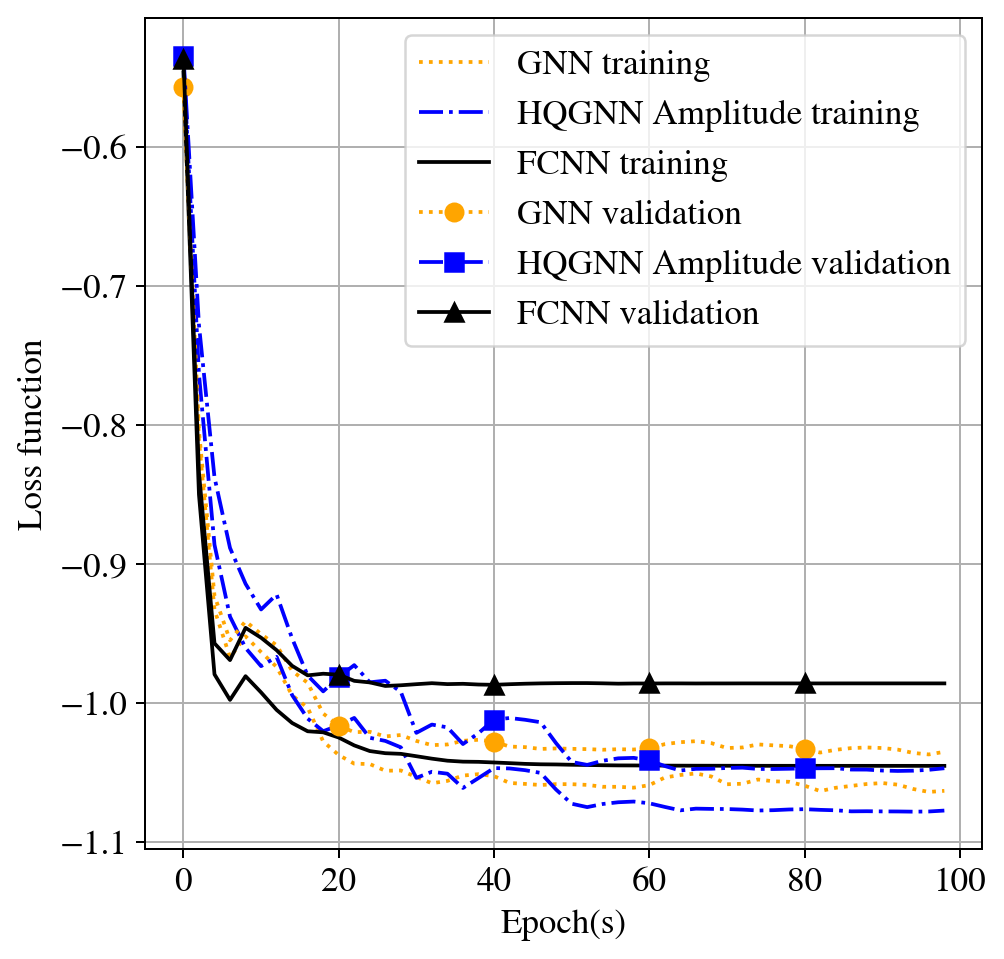

In [ ]:
# record_gnn = np.load('gnn.npy')
# record_amplitude = np.load('amplitude.npy')
# record_angle = np.load('angle.npy')

record_gnn = np.array(record_gnn)
record_amplitude = np.array(record_amplitude)
record_angle = np.array(record_angle)
record_DL = np.array(record_edge)
skip = 2
gnn_train = record_gnn[0::skip, 0]
amplitude_train = record_amplitude[0::skip, 0]
#angle_train = record_angle[0::skip, 0]
DL_train = record_DL[0::skip, 0]

gnn_test = record_gnn[0::skip, 1]
amplitude_test = record_amplitude[0::skip, 1]
#angle_test = record_angle[0::skip, 1]
DL_test = record_DL[0::skip, 1]

from scipy.signal import savgol_filter

gnn_train_smooth = savgol_filter(gnn_train, window_length=7, polyorder=3)
amplitude_train_smooth = savgol_filter(amplitude_train, window_length=7, polyorder=3)
DL_train_smooth = savgol_filter(DL_train, window_length=7, polyorder=3)

gnn_test_smooth = savgol_filter(gnn_test, window_length=7, polyorder=3)
amplitude_test_smooth = savgol_filter(amplitude_test, window_length=7, polyorder=3)
DL_test_smooth = savgol_filter(DL_test, window_length=7, polyorder=3)

plt.rc("text", usetex=False)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(6, 6), dpi=180)

x_values = np.arange(0, 100, 2)

plt.plot(x_values, gnn_train_smooth, ':',color = 'orange', label='GNN training')
plt.plot(x_values, amplitude_train_smooth, 'b-.', label='HQGNN Amplitude training')
plt.plot(x_values, DL_train_smooth, 'k-', label='FCNN training')

plt.plot(x_values, gnn_test_smooth, ':', color = 'orange',marker='o', markersize=7, label='GNN validation', markevery=10)
plt.plot(x_values, amplitude_test_smooth, 'b-.', marker='s', markersize=7, label='HQGNN Amplitude validation', markevery=10)
plt.plot(x_values, DL_test_smooth, 'k-', marker='^', markersize=7, label='FCNN validation', markevery=10)


plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.xlabel('Epoch(s)')
plt.ylabel('Loss function')
plt.legend()

plt.grid(True)
plt.show()

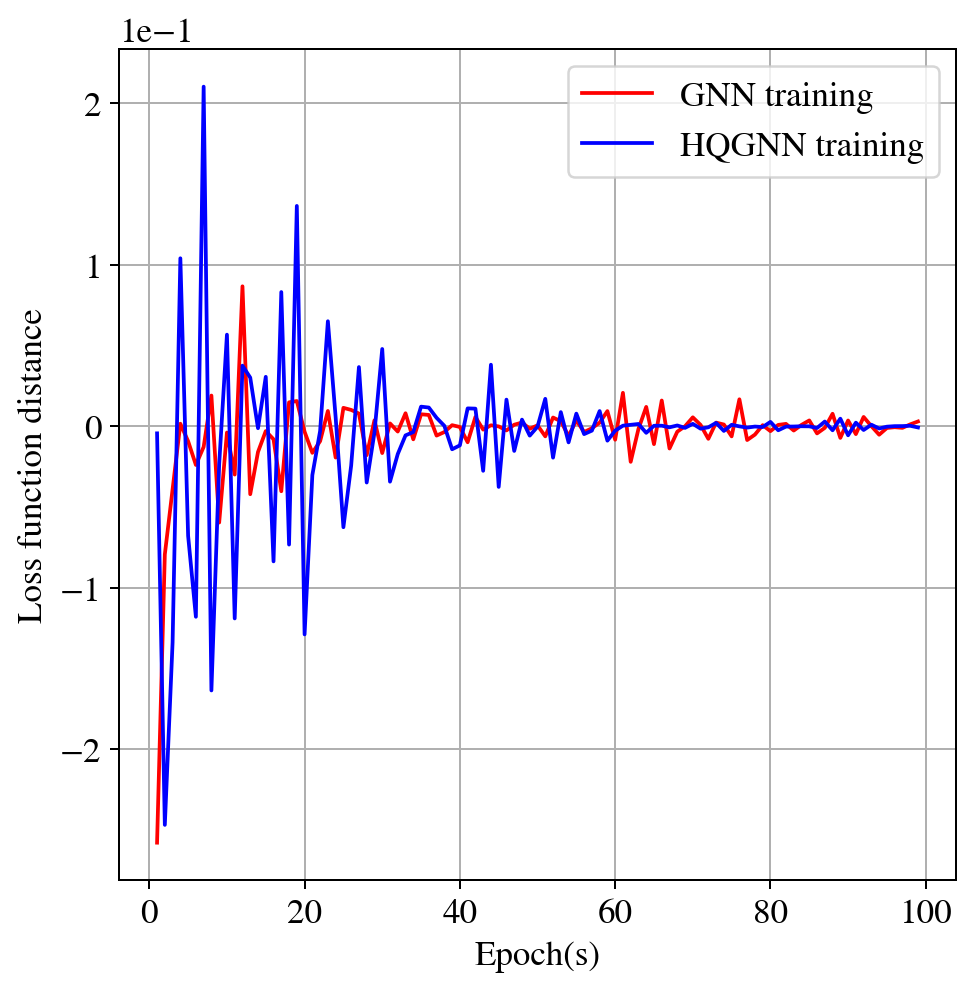

In [ ]:
# record_gnn = np.load('gnn.npy')
# record_amplitude = np.load('amplitude.npy')
# record_angle = np.load('angle.npy')


train_gnn = []
train_hqgnn = []
for i in range(1,len(record_gnn)):
    train_gnn.append(record_gnn[i][0]-record_gnn[i-1][0])
    train_hqgnn.append(record_amplitude[i][0]-record_amplitude[i-1][0])

plt.rc("text", usetex=False)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(6, 6), dpi=180)

x_values = np.arange(1, 100, 1)

plt.plot(x_values, train_gnn, 'r', label='GNN training')
plt.plot(x_values, train_hqgnn, 'b', label='HQGNN training')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.xlabel('Epoch(s)')
plt.ylabel('Loss function distance')
plt.legend()

plt.grid(True)
plt.show()

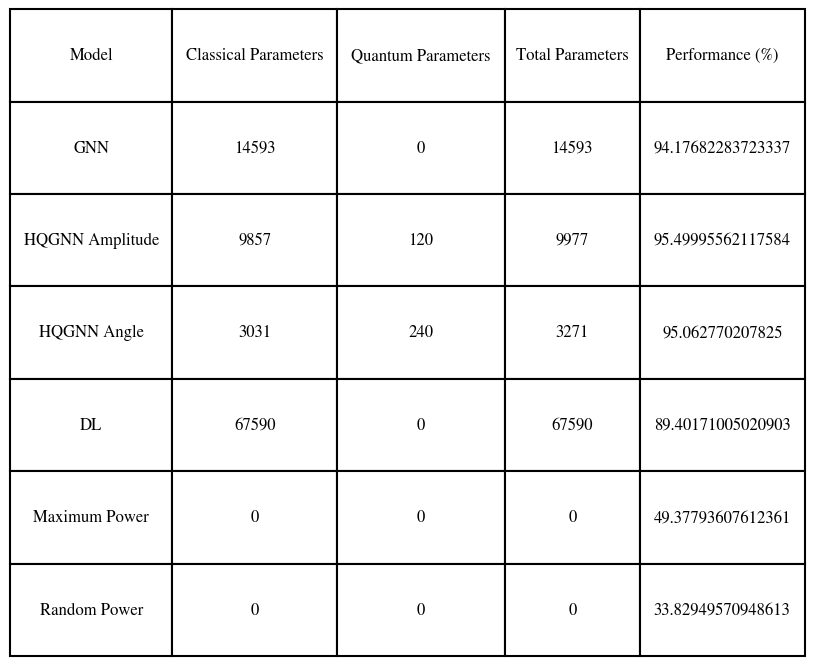

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  # Phân loại các tham số thuộc về Quantum
            quantum_params += param.numel()
        else:  # Các tham số khác thuộc về Classical
            classical_params += param.numel()
    return quantum_params, classical_params

models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_amplitude,
    "HQGNN Angle": model_qml_mid_angle,
    "DL": model_ANN,
}

params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}

avg_gnn_test_rates_angle = -test_model(test_loader, model_qml_mid_angle)
avg_gnn_test_rates_amplitude = -test_model(test_loader, model_qml_amplitude)
avg_gnn_test_rates = -test_model(test_loader, model)
avg_dl = -test_model_DL(test_loader_DL, model_ANN)

for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    full = torch.ones_like(output)
    all_one_rates = -rate_loss(full, d_test, c_test).detach().numpy()
    rand = torch.rand_like(output)
    random_rates = -rate_loss(rand, d_test, c_test).detach().numpy()

test_data = scipy.io.loadmat('cf_test_6_30.mat')
opt_rates = np.sum(test_data['R_cf_opt_min']) / len(test_loader.dataset)

# Tính hiệu suất
performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
    "DL": (avg_dl/opt_rates) * 100,
    "Maximum Power": (all_one_rates/opt_rates) * 100,
    "Random Power": (random_rates/opt_rates) * 100
}

# Tạo DataFrame chứa kết quả
data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle","DL","Maximum Power", "Random Power"],
    "Classical Parameters": [params_count["GNN"][1], params_count["HQGNN Amplitude"][1], params_count["HQGNN Angle"][1],params_count["DL"][1],0,0],
    "Quantum Parameters": [params_count["GNN"][0], params_count["HQGNN Amplitude"][0], params_count["HQGNN Angle"][0],params_count["DL"][0],0,0],
    "Total Parameters": [params_count["GNN"][0] + params_count["GNN"][1], params_count["HQGNN Amplitude"][0] + params_count["HQGNN Amplitude"][1],params_count["HQGNN Angle"][0] + params_count["HQGNN Angle"][1],params_count["DL"][0] + params_count["DL"][1],0,0],
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"], performance_percentages["HQGNN Angle"],performance_percentages["DL"], performance_percentages["Maximum Power"], performance_percentages["Random Power"]],
}


params_df = pd.DataFrame(data)

# Vẽ bảng
fig, ax = plt.subplots(figsize=(8, 4))  # Kích thước hình ảnh
ax.axis('tight')  # Loại bỏ trục
ax.axis('off')  # Loại bỏ viền trục
table = ax.table(cellText=params_df.values, colLabels=params_df.columns, loc='center', cellLoc='center')

# Tùy chỉnh bảng
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(params_df.columns))))

# Tăng khoảng cách giữa các hàng và cột
for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.5) 
    cell.set_height(0.3)   
    cell.set_width(0.25)    

plt.savefig("model_parameters_and_performance_table_full.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'model_parameters.pth')
torch.save(model_qml_amplitude.state_dict(), 'model_amplitude_parameters.pth')
torch.save(model_qml_mid_angle.state_dict(), 'model_angle_parameters.pth')

In [ ]:
# model.load_state_dict(torch.load('model_parameters.pth'))
#model_qml_amplitude.load_state_dict(torch.load('model_amplitude_parameters.pth'))
#model_qml_mid_angle.load_state_dict(torch.load('model_angle_parameters.pth'))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18840\200586683.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_parameters.pth'))


<All keys matched successfully>

In [52]:
import pandas as pd
models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_amplitude,
    "HQGNN Angle": model_qml_mid_angle,
}

params_count = {name: sum(p.numel() for p in model.parameters()) for name, model in models.items()}

avg_gnn_test_rates_angle = -test_model(test_loader, model_qml_mid_angle)
avg_gnn_test_rates_amplitude = -test_model(test_loader, model_qml_amplitude)
avg_gnn_test_rates = -test_model(test_loader, model)
test_data = scipy.io.loadmat('cf_test_6_30_2.mat')
opt_rates = np.mean(test_data['R_cf_opt_min'])


performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
}
data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle"],
    "Parameter Numbers": [params_count["GNN"], params_count["HQGNN Amplitude"], params_count["HQGNN Angle"]],
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"], performance_percentages["HQGNN Angle"]]
}
params_df = pd.DataFrame(data)
print(params_df)


             Model  Parameter Numbers  Performance (%)
0              GNN              14593        90.219719
1  HQGNN Amplitude               9977        93.445879
2      HQGNN Angle               3151        91.089128


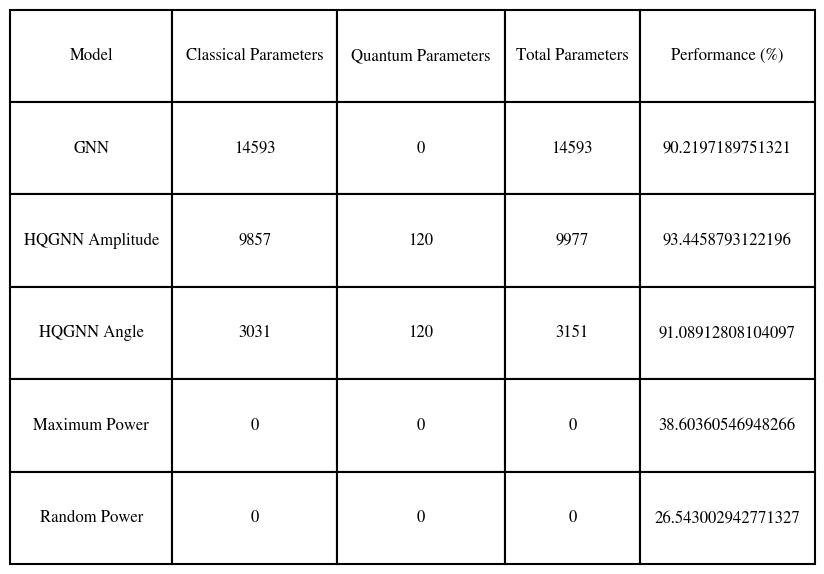

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  # Phân loại các tham số thuộc về Quantum
            quantum_params += param.numel()
        else:  # Các tham số khác thuộc về Classical
            classical_params += param.numel()
    return quantum_params, classical_params

models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_amplitude,
    "HQGNN Angle": model_qml_mid_angle,
}

params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}

avg_gnn_test_rates_angle = -test_model(test_loader, model_qml_mid_angle)
avg_gnn_test_rates_amplitude = -test_model(test_loader, model_qml_amplitude)
avg_gnn_test_rates = -test_model(test_loader, model)

for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    full = torch.ones_like(output)
    all_one_rates = -rate_loss(full, d_test, c_test).detach().numpy()
    rand = torch.rand_like(output)
    random_rates = -rate_loss(rand, d_test, c_test).detach().numpy()

test_data = scipy.io.loadmat('cf_test_6_30_2.mat')
opt_rates = np.sum(test_data['R_cf_opt_min']) / len(test_loader.dataset)

# Tính hiệu suất
performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
    "Maximum Power": (all_one_rates/opt_rates) * 100,
    "Random Power": (random_rates/opt_rates) * 100
}

# Tạo DataFrame chứa kết quả
data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle","Maximum Power", "Random Power"],
    "Classical Parameters": [params_count["GNN"][1], params_count["HQGNN Amplitude"][1], params_count["HQGNN Angle"][1],0,0],
    "Quantum Parameters": [params_count["GNN"][0], params_count["HQGNN Amplitude"][0], params_count["HQGNN Angle"][0],0,0],
    "Total Parameters": [params_count["GNN"][0] + params_count["GNN"][1], params_count["HQGNN Amplitude"][0] + params_count["HQGNN Amplitude"][1],params_count["HQGNN Angle"][0] + params_count["HQGNN Angle"][1],0,0],
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"], performance_percentages["HQGNN Angle"], performance_percentages["Maximum Power"], performance_percentages["Random Power"]],
}


params_df = pd.DataFrame(data)

# Vẽ bảng
fig, ax = plt.subplots(figsize=(8, 4))  # Kích thước hình ảnh
ax.axis('tight')  # Loại bỏ trục
ax.axis('off')  # Loại bỏ viền trục
table = ax.table(cellText=params_df.values, colLabels=params_df.columns, loc='center', cellLoc='center')

# Tùy chỉnh bảng
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(params_df.columns))))

# Tăng khoảng cách giữa các hàng và cột
for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.5) 
    cell.set_height(0.3)   
    cell.set_width(0.25)    

plt.savefig("model_parameters_and_performance_table_full.png", dpi=300, bbox_inches='tight')
plt.show()


In [81]:
torch.save(model.state_dict(), 'model_parameters.pth')
torch.save(model_qml_amplitude.state_dict(), 'model_amplitude_parameters.pth')
torch.save(model_qml_mid_angle.state_dict(), 'model_angle_parameters.pth')

In [55]:
# model.load_state_dict(torch.load('model_parameters.pth'))
# model_qml_amplitude.load_state_dict(torch.load('model_amplitude_parameters.pth'))
# model_qml_mid_angle.load_state_dict(torch.load('model_angle_parameters.pth'))

# Same Parameter

In [56]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class EdgeConv_same(MessagePassing):
    def __init__(self, input_dim, node_dim, dim_out, **kwargs):
        super(EdgeConv_same, self).__init__(aggr='mean')  # mean aggregation
        self.lin = MLP([input_dim, dim_out])
        self.res_lin = Lin(node_dim, dim_out)
        self.bn = BN(dim_out)

    def forward(self, x, edge_index, edge_attr):

        feat_src, feat_dst = x


        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)


        return self.bn(out + self.res_lin(feat_dst))

    def message(self, x_j, x_i, edge_attr):
        # Tạo ra thông điệp từ các nút nguồn, nút đích và đặc tính cạnh
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        return self.lin(out)

    def update(self, aggr_out):
        # Cập nhật giá trị nút đích sau khi tập hợp
        return aggr_out



In [57]:
class RGCN_same(nn.Module):
    def __init__(self):
        super(RGCN_same, self).__init__()
        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv_same(4, 1, 13),
            ('AP', 'com', 'UE'): EdgeConv_same(4, 1, 13)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv_same(28, 13, 13),
            ('AP', 'com', 'UE'): EdgeConv_same(28, 13, 13)
        }, aggr='mean')

        self.conv3 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv_same(28, 13, 13),
            ('AP', 'com', 'UE'): EdgeConv_same(28, 13, 13)
        }, aggr='mean')

        self.mlp = MLP([13, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self,x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out


In [83]:
model_gnn = RGCN_same()
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [84]:
trainable_params = sum(p.numel() for p in model_gnn.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3003


In [60]:
n_qubits_amplitude = 4
dev = qml.device('default.qubit', wires=n_qubits)


In [61]:
n_layers_circuit_X = 2
def circuit_X_entangling(weights, n_qubits_amplitude):
    qml.CRX(weights[-1], wires=[n_qubits_amplitude-1, 0])
    for i in range(n_qubits_amplitude-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits_amplitude), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_X):
        circuit_X_entangling(layer_weights[l], n_qubits_amplitude)
    return qml.probs(wires=range(n_qubits_amplitude))
weight_shapes_circuit_X = { "layer_weights": (n_layers_circuit_X, n_qubits_amplitude)}

In [62]:
n_layers_circuit_Z = 2
def circuit_Z_entangling(weights, n_qubits_amplitude):
    qml.CRZ(weights[-1], wires=[n_qubits_amplitude - 1, 0])
    for i in range(n_qubits_amplitude - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits_amplitude), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_Z):
        circuit_Z_entangling(layer_weights[l], n_qubits_amplitude)
    return qml.probs(wires=range(n_qubits_amplitude))
weight_shapes_circuit_Z = { "layer_weights": (n_layers_circuit_Z, n_qubits_amplitude)}

In [63]:
class Q_layer_same(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, **kwargs):
        super(Q_layer_same, self).__init__(aggr='mean')  # mean aggregation
        self.lin_res = qml.qnn.TorchLayer(circuit_Z, weight_shapes_circuit_Z)
        self.lin_qml = qml.qnn.TorchLayer(circuit_X, weight_shapes_circuit_X)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, 2 ** n_qubits_amplitude)
        self.bn = BN(2 ** n_qubits_amplitude)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(feat_dst)
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [64]:
class RGCN_Hybrid_amplitude_same(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_amplitude_same, self).__init__()
        out_dim = 2**n_qubits_amplitude
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_same(1, 1, edge_dim),
            ('AP', 'com', 'UE'): Q_layer_same(1, 1, edge_dim,)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_same(out_dim, out_dim, edge_dim),
            ('AP', 'com', 'UE'): Q_layer_same(out_dim, out_dim, edge_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer_same(out_dim, out_dim, edge_dim),
             ('AP', 'com', 'UE'): Q_layer_same(out_dim, out_dim, edge_dim)
         }, aggr='mean')

        self.mlp = MLP([16, 20])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(20, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [65]:
model_amplitude_same = RGCN_Hybrid_amplitude_same().to()

optimizer_amplitude_same = torch.optim.Adam(model_amplitude_same.parameters(), lr=5e-4)
scheduler_amplitude_same = torch.optim.lr_scheduler.StepLR(optimizer_amplitude_same, step_size=10, gamma=0.6)

In [66]:
trainable_params = sum(p.numel() for p in model_amplitude_same.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3089


In [85]:
record_gnn_same = []

for epoch in range(0, 100):
    if epoch % 1 == 0:
        with torch.no_grad():
            test_rate = test_model(test_loader, model_gnn)
            train_rate = test_model(train_loader, model_gnn)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
        record_gnn_same.append([train_rate, test_rate])

    train_model(epoch, model_gnn, optimizer, train_loader )
    scheduler.step()


Epoch 000, Train Rate: -0.2348, Test Rate: -0.2585
Epoch 001, Train Rate: -0.3090, Test Rate: -0.3311
Epoch 002, Train Rate: -0.3564, Test Rate: -0.3769
Epoch 003, Train Rate: -0.4001, Test Rate: -0.4180
Epoch 004, Train Rate: -0.4514, Test Rate: -0.4666
Epoch 005, Train Rate: -0.5162, Test Rate: -0.5276
Epoch 006, Train Rate: -0.5449, Test Rate: -0.5556
Epoch 007, Train Rate: -0.5520, Test Rate: -0.5611
Epoch 008, Train Rate: -0.5646, Test Rate: -0.5731
Epoch 009, Train Rate: -0.5770, Test Rate: -0.5850
Epoch 010, Train Rate: -0.5927, Test Rate: -0.5993
Epoch 011, Train Rate: -0.5944, Test Rate: -0.6003
Epoch 012, Train Rate: -0.5969, Test Rate: -0.6028
Epoch 013, Train Rate: -0.5995, Test Rate: -0.6051
Epoch 014, Train Rate: -0.6087, Test Rate: -0.6129
Epoch 015, Train Rate: -0.6086, Test Rate: -0.6126
Epoch 016, Train Rate: -0.6105, Test Rate: -0.6141
Epoch 017, Train Rate: -0.6146, Test Rate: -0.6177
Epoch 018, Train Rate: -0.6076, Test Rate: -0.6114
Epoch 019, Train Rate: -0.6141,

In [68]:
record_amplitude_same = []

for epoch in range(0, 100):

    with torch.no_grad():
        test_rate = test_model(test_loader, model_amplitude_same)
        train_rate = test_model(train_loader, model_amplitude_same)
        record_amplitude_same.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model(epoch, model_amplitude_same, optimizer_amplitude_same, train_loader)
    scheduler_amplitude_same.step()

Epoch 00, Train Rate: -0.2378, Test Rate: -0.2615
Epoch 01, Train Rate: -0.5102, Test Rate: -0.5175
Epoch 02, Train Rate: -0.5456, Test Rate: -0.5506
Epoch 03, Train Rate: -0.5179, Test Rate: -0.5229
Epoch 04, Train Rate: -0.5822, Test Rate: -0.5850
Epoch 05, Train Rate: -0.4197, Test Rate: -0.4173
Epoch 06, Train Rate: -0.5995, Test Rate: -0.6003
Epoch 07, Train Rate: -0.5608, Test Rate: -0.5571
Epoch 08, Train Rate: -0.5860, Test Rate: -0.5902
Epoch 09, Train Rate: -0.5073, Test Rate: -0.5039
Epoch 10, Train Rate: -0.5480, Test Rate: -0.5495
Epoch 11, Train Rate: -0.5800, Test Rate: -0.5762
Epoch 12, Train Rate: -0.6058, Test Rate: -0.6078
Epoch 13, Train Rate: -0.5873, Test Rate: -0.5898
Epoch 14, Train Rate: -0.4871, Test Rate: -0.4871
Epoch 15, Train Rate: -0.6005, Test Rate: -0.6008
Epoch 16, Train Rate: -0.4668, Test Rate: -0.4684
Epoch 17, Train Rate: -0.6027, Test Rate: -0.6030
Epoch 18, Train Rate: -0.5636, Test Rate: -0.5658
Epoch 19, Train Rate: -0.6394, Test Rate: -0.6380


In [69]:
torch.save(model_gnn.state_dict(), 'model_gnn_same.pth')
torch.save(model_amplitude_same.state_dict(), 'model_amplitude_same.pth')

# HQGNN Angle 

In [70]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 5
dev = qml.device('default.qubit', wires=n_qubits)


In [71]:
n_layers_circuit_X2 = 1
def circuit_X2_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_X2):
        circuit_X2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X2 = { "layer_weights": (n_layers_circuit_X2, n_qubits)}

In [72]:
n_layers_circuit_Z2 = 1
def circuit_Z2_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_Z2):
        circuit_Z2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z2 = { "layer_weights": (n_layers_circuit_Z2, n_qubits)}

In [73]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer_angle(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, out_dim, **kwargs):
        super(Q_layer_angle, self).__init__(aggr='mean')  
        self.lin_res = qml.qnn.TorchLayer(circuit_X2, weight_shapes_circuit_X2)
        self.lin_qml = qml.qnn.TorchLayer(circuit_Z2, weight_shapes_circuit_Z2)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, out_dim)
        self.linear = nn.Linear(dst_dim, n_qubits)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(self.linear(feat_dst))
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [74]:
class RGCN_Hybrid_angle_same(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_angle_same, self).__init__()
        out_dim = n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(1, 1, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(1, 1, edge_dim,out_dim)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
             ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [75]:
model_angle_same = RGCN_Hybrid_angle_same().to()

optimizer_qml_mid_angle = torch.optim.Adam(model_angle_same.parameters(), lr=5e-4)
scheduler_qml_mid_angle = torch.optim.lr_scheduler.StepLR(optimizer_qml_mid_angle, step_size=10, gamma=0.6)

In [76]:
trainable_params = sum(p.numel() for p in model_angle_same.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3091


In [77]:
record_edge = []

for epoch in range(0, 100):

    with torch.no_grad():
        test_rate = test_model(test_loader, model_angle_same)
        train_rate = test_model(train_loader, model_angle_same)
        record_edge.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model(epoch, model_angle_same, optimizer_qml_mid_angle, train_loader)
    scheduler_qml_mid_angle.step()

Epoch 00, Train Rate: -0.2411, Test Rate: -0.2649
Epoch 01, Train Rate: -0.5009, Test Rate: -0.5149
Epoch 02, Train Rate: -0.5718, Test Rate: -0.5807
Epoch 03, Train Rate: -0.5964, Test Rate: -0.5994
Epoch 04, Train Rate: -0.6044, Test Rate: -0.6056
Epoch 05, Train Rate: -0.6086, Test Rate: -0.6102
Epoch 06, Train Rate: -0.4542, Test Rate: -0.4600
Epoch 07, Train Rate: -0.6220, Test Rate: -0.6217
Epoch 08, Train Rate: -0.6250, Test Rate: -0.6273
Epoch 09, Train Rate: -0.6278, Test Rate: -0.6282
Epoch 10, Train Rate: -0.6104, Test Rate: -0.6143
Epoch 11, Train Rate: -0.6131, Test Rate: -0.6151
Epoch 12, Train Rate: -0.6354, Test Rate: -0.6375
Epoch 13, Train Rate: -0.6343, Test Rate: -0.6374
Epoch 14, Train Rate: -0.6327, Test Rate: -0.6337
Epoch 15, Train Rate: -0.5334, Test Rate: -0.5377
Epoch 16, Train Rate: -0.6314, Test Rate: -0.6334
Epoch 17, Train Rate: -0.6378, Test Rate: -0.6409
Epoch 18, Train Rate: -0.6406, Test Rate: -0.6417
Epoch 19, Train Rate: -0.6389, Test Rate: -0.6430


In [78]:
torch.save(model_angle_same.state_dict(), 'model_angle_same.pth')

In [ ]:
class ANN_same(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=6, out_features=16)  
        self.fc2 = nn.Linear(in_features=16, out_features=60)  
        self.fc3 = nn.Linear(in_features=60, out_features=30)  
        self.output = nn.Linear(in_features=30, out_features=6)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))     
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.output(x))
        return x

In [ ]:
model_ANN_same = ANN_same()
optimizer_ANN_same = torch.optim.Adam(model_ANN_same.parameters(), lr = 5e-3)
scheduler_ANN_same = torch.optim.lr_scheduler.StepLR(optimizer_ANN_same, step_size=10, gamma = 1/3)
trainable_params = sum(p.numel() for p in model_ANN_same.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

In [ ]:
record_edge = []

for epoch in range(0, 100):

    with torch.no_grad():
        test_rate = test_model_DL(test_loader_DL, model_ANN_same)
        train_rate = test_model_DL(train_loader_DL, model_ANN_same)
        record_edge.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model_DL(model_ANN_same, optimizer_ANN_same, train_loader_DL)
    scheduler_ANN_same.step()

In [ ]:
import pandas as pd

# Hàm để đếm tham số của mô hình
def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  # Phân loại các tham số thuộc về Quantum
            quantum_params += param.numel()
        else:  # Các tham số khác thuộc về Classical
            classical_params += param.numel()
    return quantum_params, classical_params

models = {
    "GNN": model_gnn,
    "HQGNN Amplitude": model_amplitude_same,
    "HQGNN Angle": model_angle_same,
    "DL":model_ANN_same
}

params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}



avg_gnn_test_rates_angle = -test_model(test_loader, model_angle_same)
avg_gnn_test_rates_amplitude = -test_model(test_loader, model_amplitude_same)
avg_gnn_test_rates = -test_model(test_loader, model_gnn)
avg_dl = -test_model_DL(test_loader_DL, model_ANN_same)
test_data = scipy.io.loadmat('cf_test_6_30_2.mat')
opt_rates = np.sum(test_data['R_cf_opt_min'])/len(test_loader.dataset)

# Hiệu suất
performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
    "DL":(avg_dl/opt_rates) * 100,

}

# Tạo DataFrame
data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle","FCNN"],
    "Classical Parameters": [params_count["GNN"][1], params_count["HQGNN Amplitude"][1], params_count["HQGNN Angle"][1], params_count["DL"][1]],
    "Quantum Parameters": [params_count["GNN"][0], params_count["HQGNN Amplitude"][0], params_count["HQGNN Angle"][0],params_count["DL"][0]],
    
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"], performance_percentages["HQGNN Angle"], performance_percentages["DL"]],
}

params_df = pd.DataFrame(data)

print(params_df)


             Model  Classical Parameters  Quantum Parameters  Performance (%)
0              GNN                  3003                   0        86.858594
1  HQGNN Amplitude                  2993                  96        92.521612
2      HQGNN Angle                  3031                  60        90.236682
